#  Final Year Project(Artificial Neural Network Model)


In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import ipaddress
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay


# ============================
# Step 1: Load and Inspect Data
# ============================

In [5]:
print("="*50)
print("STEP 1: Loading and Initial Data Inspection")
print("="*50)

df = pd.read_csv(r'C:\Users\flavi\Downloads\Dataset_output.csv')

print("\nTotal Rows in Dataset:", df.shape[0])
print("\nInitial DataFrame Structure:")
print(df.head())
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values Count:")
print(df.isnull().sum())
print("\nInitial Class Distribution:")
print(df['Attack'].value_counts(dropna=False))

STEP 1: Loading and Initial Data Inspection

Total Rows in Dataset: 11866

Initial DataFrame Structure:
  Timestamp                Source_IPv6           Destination_IPv6 Protocol  \
0         0  fe80::f03a:fcb7:df24:1071  fe80::3fca:458b:5308:ca09   ICMPv6   
1  6.00E-06  fe80::3fca:458b:5308:ca09  fe80::f03a:fcb7:df24:1071   ICMPv6   
2  0.876906  fe80::f03a:fcb7:df24:1071  fe80::3fca:458b:5308:ca09   ICMPv6   
3  0.876914  fe80::3fca:458b:5308:ca09  fe80::f03a:fcb7:df24:1071   ICMPv6   
4  1.879208  fe80::f03a:fcb7:df24:1071  fe80::3fca:458b:5308:ca09   ICMPv6   

   Length                                               Info  Attack  
0     118  Echo (ping) request id=0xa079, seq=10, hop lim...       0  
1     118  Echo (ping) reply id=0xa079, seq=10, hop limit...       0  
2     118  Echo (ping) request id=0xa079, seq=1480, hop l...       0  
3     118  Echo (ping) reply id=0xa079, seq=1480, hop lim...       0  
4     118  Echo (ping) request id=0xa079, seq=3214, hop l...       0  



# ======================
# Step 2: Data Cleaning
# ======================

In [6]:
print("\n" + "="*50)
print("STEP 2: Data Cleaning")
print("="*50)

def parse_timestamp(ts):
    try:
        if isinstance(ts, (int, float)) or (isinstance(ts, str) and ts.replace('.', '', 1).isdigit()):
            return float(ts)
        parsed = pd.to_datetime(ts, format='%m/%d-%H:%M:%S.%f', errors='coerce')
        return parsed.timestamp() if pd.notnull(parsed) else np.nan
    except:
        return np.nan

df['Timestamp'] = df['Timestamp'].apply(parse_timestamp)
df['Timestamp'] = df['Timestamp'] - df['Timestamp'].min()
df['Timestamp'] = df['Timestamp'].fillna(df['Timestamp'].mean())

df['Length'] = df['Length'].replace(0, df['Length'].median())

duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
print("\nNumber of Duplicate Rows Removed:", duplicates)

df['Attack'] = df['Attack'].astype(int)

print("\nClass Distribution After Cleaning:")
print(df['Attack'].value_counts(dropna=False))


STEP 2: Data Cleaning

Number of Duplicate Rows Removed: 3

Class Distribution After Cleaning:
Attack
1    5933
0    5930
Name: count, dtype: int64


# =====================================================================================
# Step 3: Feature Engineering and Step 3.5: Filter Only ICMPv6 Flood and Normal Traffic
# =====================================================================================

In [7]:
print("\n" + "="*50)
print("STEP 3: Feature Selection and Engineering")
print("="*50)

def ipv6_to_int(ip):
    try:
        return int(ipaddress.IPv6Address(ip))
    except:
        return 0

df['Source_IPv6_int'] = df['Source_IPv6'].apply(ipv6_to_int)
df['Destination_IPv6_int'] = df['Destination_IPv6'].apply(ipv6_to_int)

df['is_ICMPv6_flood'] = df['Info'].str.contains('ICMPv6 Flood Detected', case=False, na=False).astype(int)

df = pd.get_dummies(df, columns=['Protocol'], prefix='Protocol', dummy_na=False)

feature_cols = ['Timestamp', 'Length', 'is_ICMPv6_flood', 'Source_IPv6_int', 'Destination_IPv6_int'] \
               + [col for col in df.columns if col.startswith('Protocol_')]
features = df[feature_cols]
target = df['Attack']

print("\nFeature Statistics:")
print(features.describe())
print("\nClass Distribution:")
print(target.value_counts())

print("\nFiltering dataset to include only ICMPv6 Flood Detected and Normal traffic...")

df_filtered = df[(df['is_ICMPv6_flood'] == 1) | (df['Attack'] == 0)]

features = df_filtered[feature_cols]
target = df_filtered['Attack']

print("Filtered Class Distribution:")
print(target.value_counts())


STEP 3: Feature Selection and Engineering

Feature Statistics:
          Timestamp        Length  is_ICMPv6_flood
count  1.186300e+04  11863.000000     11863.000000
mean   1.098477e+09    118.037764         0.499705
std    1.098568e+09      2.332919         0.500021
min    0.000000e+00    118.000000         0.000000
25%    1.481391e+03    118.000000         0.000000
50%    1.098292e+09    118.000000         0.000000
75%    2.197323e+09    118.000000         1.000000
max    2.197324e+09    290.000000         1.000000

Class Distribution:
Attack
1    5933
0    5930
Name: count, dtype: int64

Filtering dataset to include only ICMPv6 Flood Detected and Normal traffic...
Filtered Class Distribution:
Attack
0    5930
1    5928
Name: count, dtype: int64


# ===========================
# Step 4: Data Preprocessing
# ===========================

In [8]:
print("\n" + "="*50)
print("STEP 4: Data Preprocessing")
print("="*50)

X_train, X_test, y_train, y_test = train_test_split(
    features, target,
    test_size=0.3,
    random_state=42,
    stratify=target
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTraining set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)
print("\nTraining Class Distribution:")
print(y_train.value_counts())
print("Test Class Distribution:")
print(y_test.value_counts())


STEP 4: Data Preprocessing

Training set shape: (8300, 9)
Test set shape: (3558, 9)

Training Class Distribution:
Attack
0    4151
1    4149
Name: count, dtype: int64
Test Class Distribution:
Attack
1    1779
0    1779
Name: count, dtype: int64


# ==============================================================================================
# Step 5: ANN Model Training and Step 5A: Wrap ANN in KerasClassifier for sklearn compatibility
# ===============================================================================================


STEP 5: ANN Model Training
Epoch 1/100


C:\Users\flavi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9735 - loss: 0.1986 - val_accuracy: 1.0000 - val_loss: 9.0572e-04 - learning_rate: 0.0010
Epoch 2/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 1.4801e-04 - learning_rate: 0.0010
Epoch 3/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.0869e-04 - val_accuracy: 1.0000 - val_loss: 5.4711e-05 - learning_rate: 0.0010
Epoch 4/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 2.0721e-04 - val_accuracy: 1.0000 - val_loss: 2.5741e-05 - learning_rate: 0.0010
Epoch 5/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.3406e-04 - val_accuracy: 1.0000 - val_loss: 1.3891e-05 - learning_rate: 0.0010
Epoch 6/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.3546e-05 - val_accuracy: 1.0000 - val_loss: 4.7551e-06 - learning_rate: 0.0010
Epoch 7/100
179/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

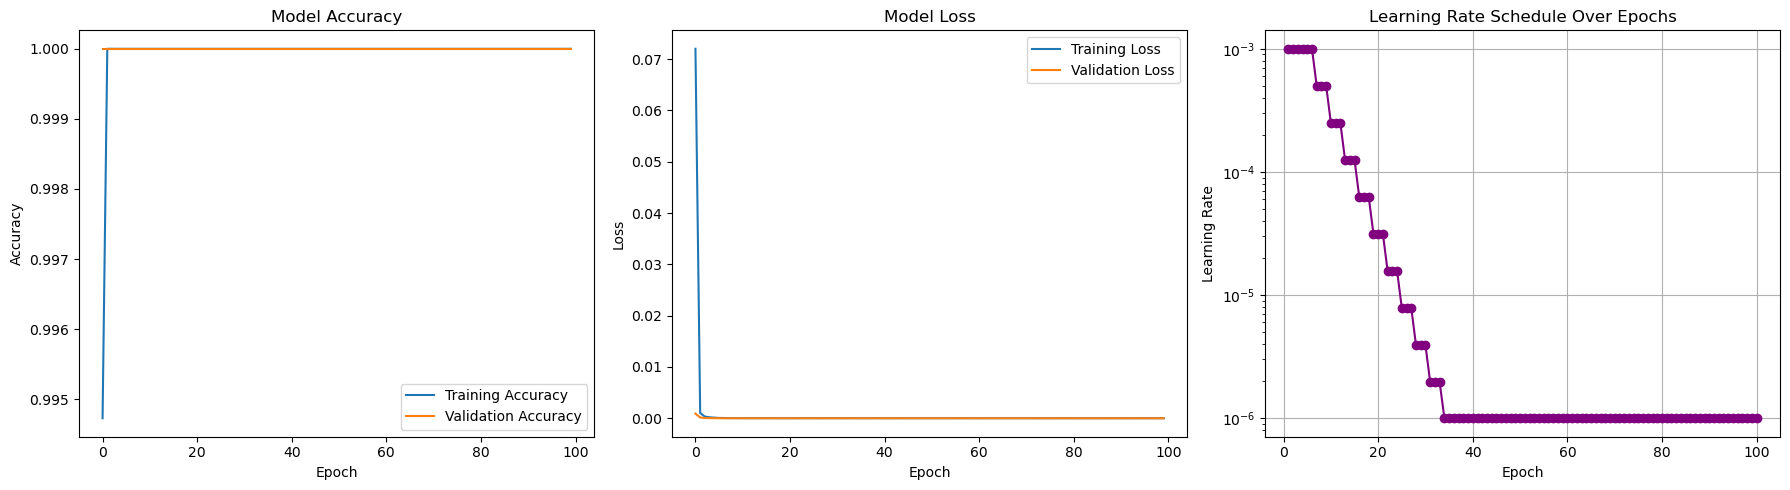


Wrapping ANN in KerasClassifier for sklearn compatibility...


C:\Users\flavi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\flavi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\flavi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs


Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0


In [9]:
print("\n" + "="*50)
print("STEP 5: ANN Model Training")
print("="*50)

def create_ann_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

input_dim = X_train_scaled.shape[1]
ann_model = create_ann_model(input_dim)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
import matplotlib.pyplot as plt
import numpy as np

# Custom callback to log learning rate
class LearningRateLogger(Callback):
    def __init__(self):
        super().__init__()
        self.lr_history = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy()  # Corrected: use learning_rate instead of lr
        self.lr_history.append(lr)

# Define ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by half
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6,  # Minimum learning rate
    verbose=1
)

# Initialize learning rate logger
lr_logger = LearningRateLogger()

# Update the fit call to include new callbacks
history = ann_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler, lr_logger],  # Updated to include new callbacks
    verbose=1
)

# Plot accuracy, loss, and learning rate
plt.figure(figsize=(18, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# --- NEW CODE START ---
# Learning rate plot
plt.subplot(1, 3, 3)
plt.plot(range(1, len(lr_logger.lr_history) + 1), lr_logger.lr_history, marker='o', color='purple')
plt.title('Learning Rate Schedule Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')  # Log scale for better visualization of small learning rates
plt.grid(True)
# --- NEW CODE END ---

plt.tight_layout()
plt.show()

print("\nWrapping ANN in KerasClassifier for sklearn compatibility...")

ann_sklearn = KerasClassifier(
    model=create_ann_model,
    input_dim=input_dim,
    epochs=50,
    batch_size=32,
    verbose=0
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(ann_sklearn, X_train_scaled, y_train, cv=skf, scoring='accuracy')

print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())


# ===========================
# Step 6: Probability Calibration
# ===========================


STEP 6: Probability Calibration using CalibratedClassifierCV


C:\Users\flavi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\flavi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\flavi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs


Confusion Matrix (Calibrated ANN):
[[1779    0]
 [   0 1779]]


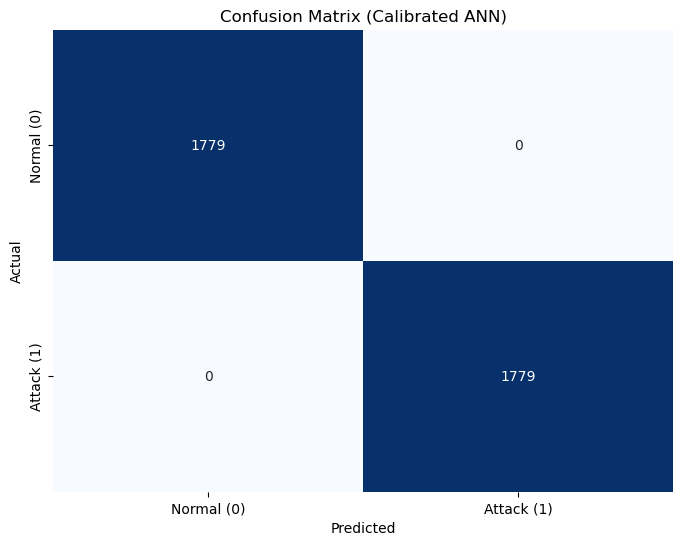


Calibrated ROC AUC: 1.0000


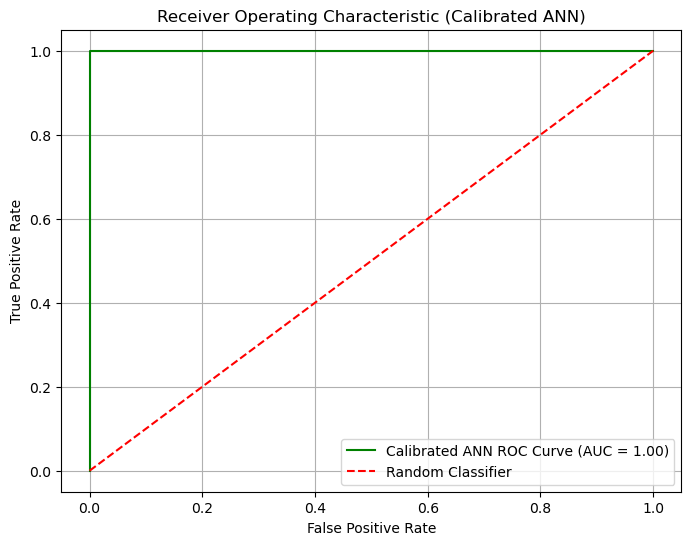


Classification Report (Calibrated ANN):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1779
           1       1.00      1.00      1.00      1779

    accuracy                           1.00      3558
   macro avg       1.00      1.00      1.00      3558
weighted avg       1.00      1.00      1.00      3558


Accuracy (Calibrated ANN): 1.0000


In [10]:
print("\n" + "="*50)
print("STEP 6: Probability Calibration using CalibratedClassifierCV")
print("="*50)

calibrated_ann = CalibratedClassifierCV(estimator=ann_sklearn, method='sigmoid', cv=5)

calibrated_ann.fit(X_train_scaled, y_train)

# Predict calibrated probabilities
y_proba_calibrated = calibrated_ann.predict_proba(X_test_scaled)[:, 1]
y_pred_calibrated = (y_proba_calibrated > 0.5).astype(int)

# Evaluate calibrated model
cm_cal = confusion_matrix(y_test, y_pred_calibrated)
print("\nConfusion Matrix (Calibrated ANN):")
print(cm_cal)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_cal, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal (0)', 'Attack (1)'],
            yticklabels=['Normal (0)', 'Attack (1)'])
plt.title('Confusion Matrix (Calibrated ANN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr_cal, tpr_cal, thresholds_cal = roc_curve(y_test, y_proba_calibrated)
auc_cal = roc_auc_score(y_test, y_proba_calibrated)

print(f"\nCalibrated ROC AUC: {auc_cal:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_cal, tpr_cal, color='green', label=f'Calibrated ANN ROC Curve (AUC = {auc_cal:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.title('Receiver Operating Characteristic (Calibrated ANN)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

print("\nClassification Report (Calibrated ANN):")
print(classification_report(y_test, y_pred_calibrated))
print(f"\nAccuracy (Calibrated ANN): {accuracy_score(y_test, y_pred_calibrated):.4f}")

# ===========================
# Step 7: Calibration Curves Comparison
# ===========================


STEP 7: Calibration Curves
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Figure size 1000x600 with 0 Axes>

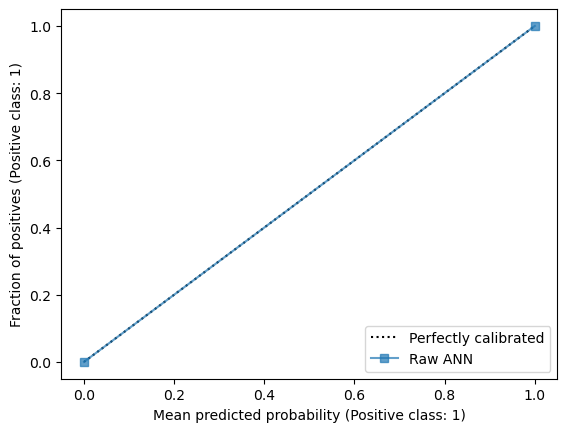

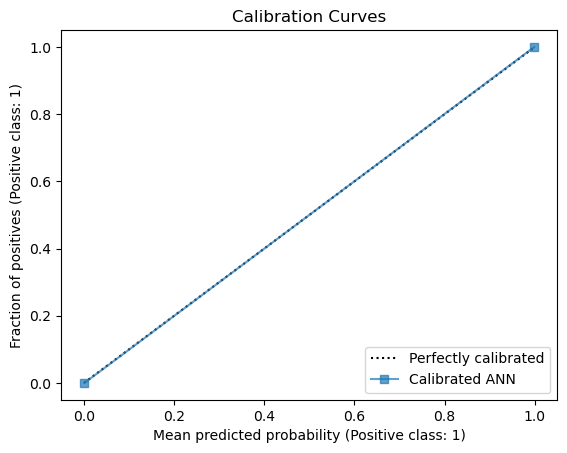

In [11]:
print("\n" + "="*50)
print("STEP 7: Calibration Curves")
print("="*50)

# Raw ANN probabilities
y_proba_raw = ann_model.predict(X_test_scaled).ravel()

plt.figure(figsize=(10, 6))

CalibrationDisplay.from_predictions(y_test, y_proba_raw, n_bins=10, name='Raw ANN', alpha=0.7)
CalibrationDisplay.from_predictions(y_test, y_proba_calibrated, n_bins=10, name='Calibrated ANN', alpha=0.7)

plt.title('RAW Curves')
plt.title('Calibration Curves')
plt.show()

# ===========================
# Step 8: Feature Importance via ANN Input Layer Weights
# ===========================


STEP 8: Feature Importance via ANN Input Layer Weights

Normalized Feature Importance from ANN:
                Feature  Importance  Normalized_Importance
0             Timestamp   11.841759               1.000000
6       Protocol_ICMPv6   11.721724               0.963319
7    Protocol_IPV6-ICMP   10.719519               0.657063
2       is_ICMPv6_flood   10.253531               0.514666
5         Protocol_ICMP   10.100570               0.467924
3       Source_IPv6_int    9.921537               0.413215
1                Length    9.909153               0.409430
4  Destination_IPv6_int    9.481356               0.278703
8          Protocol_UDP    8.569317               0.000000


C:\Users\flavi\AppData\Local\Temp\ipykernel_19868\2493669344.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Normalized_Importance', y='Feature', data=ann_feature_importance_df, palette='viridis')


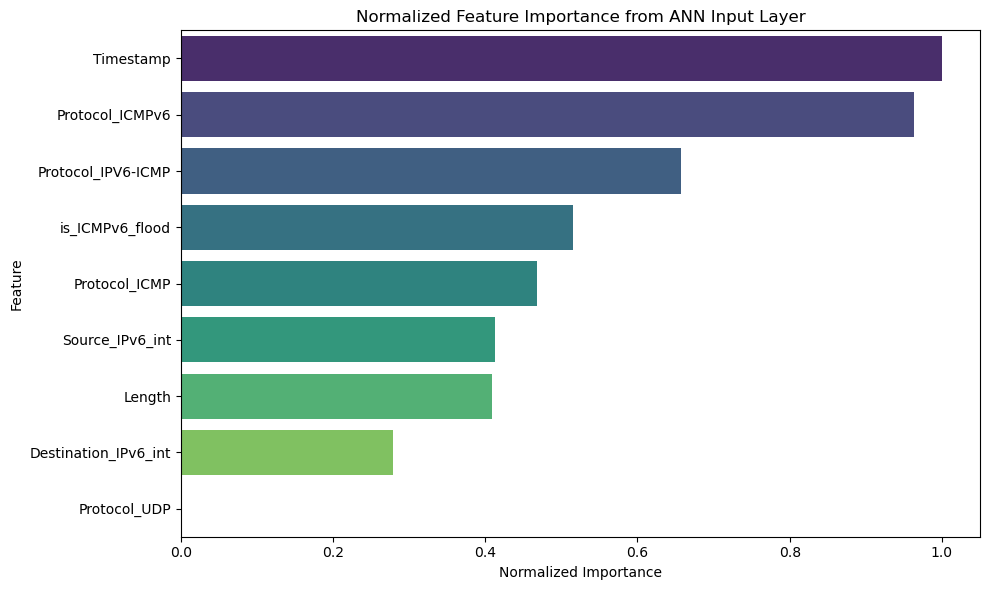

In [12]:
print("\n" + "="*50)
print("STEP 8: Feature Importance via ANN Input Layer Weights")
print("="*50)

# Get weights and biases from the first Dense layer
weights, biases = ann_model.layers[0].get_weights()

# Calculate importance: sum of absolute weights for each input feature
feature_importance_weights = np.sum(np.abs(weights), axis=1)

# Min-max normalization
min_w = feature_importance_weights.min()
max_w = feature_importance_weights.max()
if max_w != min_w:
    normalized_weights = (feature_importance_weights - min_w) / (max_w - min_w)
else:
    normalized_weights = feature_importance_weights  # No need to normalize if all same

# Create DataFrame for comparison
ann_feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance_weights,
    'Normalized_Importance': normalized_weights
}).sort_values(by='Normalized_Importance', ascending=False)

print("\nNormalized Feature Importance from ANN:")
print(ann_feature_importance_df)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Normalized_Importance', y='Feature', data=ann_feature_importance_df, palette='viridis')
plt.title('Normalized Feature Importance from ANN Input Layer')
plt.xlabel('Normalized Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# ===========================
# Step 9: Save Model and Scaler
# ===========================

In [13]:
print("\n" + "="*50)
print("STEP 9: Saving Model and Scaler")
print("="*50)

from tensorflow.keras.models import save_model

save_model(ann_model, 'ann_model.h5')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(feature_cols, "ann_features.pkl")

print("ANN model saved as 'ann_model.h5'")
print("Scaler saved as 'scaler.pkl'")


STEP 9: Saving Model and Scaler
ANN model saved as 'ann_model.h5'
Scaler saved as 'scaler.pkl'
